In [ ]:
## ***
## NOTE: edit default_device() in common/torch/ops.py for your gpu
## ***
###

## versions:
## Python    : 3.11.5
## numpy     : 1.26.0
## torch     : 2.1.0
## pandas    : 2.1.1

# licensed under the Creative Commons - Attribution-NonCommercial 4.0
# International license (CC BY-NC 4.0):
# https://creativecommons.org/licenses/by-nc/4.0/. 

In [1]:
import os
import io
import sys
import shutil
import datetime
import requests
from typing import Dict, List, Optional

import numpy as np
import pandas as pd
import torch as t
from torch.utils.data import DataLoader
from scipy import stats

from common.sampler import ts_dataset
from common.torch.snapshots import SnapshotManager
from experiments.trainer import trainer_var
from experiments.model import generic_dec_var
from models.exog import LSTM_test, TCN_encoder


In [2]:
import matplotlib.pyplot as plt

## not the actual loss fn, just for comparing different forecasts
def calc_loss(forecasts, name, test_targets, horizon):
    #lfn = t.nn.functional.l1_loss
    #def lfn(a,b):
    #    x = ((a-b)/b)
    #    return x.abs().nanmean()
    def lfn(a,b):
        return 2.0 * t.nn.functional.l1_loss(a,b) / (a.nanmean() + b.nanmean())
    
    return lfn(t.tensor(np.array(forecasts[name],dtype=np.float32))[:,:horizon], 
               t.tensor(np.array(test_targets,dtype=np.float32))[:,:horizon])

def plotpred(forecasts, name, ser, training_targets, test_targets, horizon, lower_fc=None, upper_fc=None):
    x_start = 0
    x_end = training_targets.shape[1]
    colors = ["black","orangered"]
    #colors = ["white","yellow"]
    _, ax = plt.subplots(figsize=(7,5))
    ax.grid(alpha=0.2)
    ax.plot(np.arange(x_start,x_end),training_targets[ser,x_start:x_end],color=colors[0],linewidth=0.5)
    if test_targets is not None:
        ax.plot(np.arange(x_end,x_end+horizon),test_targets[ser,0:horizon],color=colors[0],linewidth=0.5)
    ax.plot(np.arange(x_end,x_end+horizon),forecasts[name][ser],color=colors[1],linewidth=1.5,alpha=0.8)
    if upper_fc is not None:
        ax.fill_between(np.arange(x_end,x_end+horizon),lower_fc[name][ser],upper_fc[name][ser],color=colors[1],alpha=0.4)
    plt.show()
    

In [3]:
## this fn returns a function suitable for using in a loop to generate an ensemble

def training_fn(training_data: Dict[str, np.ndarray], 
                static_categories: np.ndarray, 
                target_key: str,
                horizon: int, ## forecast horizon
                windowed_norm: bool, ## whether the model should normalize the target data by sample window
                init_LR = 0.001, ## initial learning rate; default from nbeats; should probably use lower
                batch_size = 1024): ## default batch size from nbeats; should probably use lower

    enc_temporal = True ## generate an encoding that preserves temporal structure
    static_cat_embed_dim = 3 ## dimension of vector embedding if using static_categories
    history_size_in_horizons = 60 ## maximum length of history to consider for training, in # of horizons

    ## used in the fn below
    def generate_forecast(m, data_iterator):
        x, x_mask, cat_tensor = data_iterator.last_insample_window()
        m.eval()
        with t.no_grad():
            f_mu, f_var = m(x, x_mask, cat_tensor)
        return f_mu.cpu().detach().numpy(), f_var.cpu().detach().numpy()

    ## result fn returns forecast; model is saved in snapshots folder
    def ret_fn(model_name: str, 
                iterations: int, 
                lookback: int, ## backwards window size, in # of horizons
                use_exog_vars: List[str], 
                use_static_cat: bool, ## if true, static category will be transformed into a vector embedding
                loss_fn_name: str,
                nbeats_stacks: int = 8, ## number of layer stacks; more data can support a deeper model
                nbeats_hidden_dim: int = 512, ## longer input sequence needs larger hidden dimension
                nbeats_dropout: Optional[float] = None,
                encoder_k: int = 3,
                encoder_n: Optional[int] = None, ## calculated below if missing
                encoder_hidden_dim: int = 128,
                encoder_dropout: float = 0.2): ## default for TCN from Bai et al

        input_size = lookback * horizon  ## backward window size, in time units
        use_vars = [target_key, *use_exog_vars]
        ## training data dims are [series, time, variables]
        ## where the first variable is the target, and the rest are covariates
        training_values = np.stack(
                            [training_data[k] for k in use_vars]
                            ).transpose([1,2,0])
        
        n_features = training_values.shape[2] - 1 ## number of exogenous covariates
        n_embed = static_categories.shape[0] if use_static_cat else 0
        embed_dim = static_cat_embed_dim if use_static_cat else 0

        if encoder_n is None: ## use minimum needed to cover input size
            ## TCN receptive field size = 2(k-1)(2^n - 1)+1 where k is kernel size and n is # blocks
            encoder_n = int(np.ceil(np.log2(1.0 + (0.5*(input_size - 1.0) / (encoder_k - 1.0)))))

        exog_block = TCN_encoder(n_features, [encoder_hidden_dim]*encoder_n, encoder_k, encoder_dropout, enc_temporal, n_embed, embed_dim)
        ## same idea, but using LSTM; TCN encoder seems to work slightly better (but has more moving parts)
        #exog_block = LSTM_test(n_features=n_features,input_size=input_size,output_size=horizon,layer_size=-1,n_embed=n_embed,embed_dim=embed_dim,decoder_extra_layers=0,
        #            lstm_layers=1,lstm_hidden=enc_hid,temporal=enc_temporal,decode=False)

        enc_dim = input_size if enc_temporal else encoder_hidden_dim
        ## constructs the model; defined in experiments/model.py
        model = generic_dec_var(enc_dim=enc_dim, output_size=horizon,
                        stacks = nbeats_stacks,
                        layers = 4,  ## 4 per stack, from the nbeats paper
                        layer_size = nbeats_hidden_dim,
                        exog_block = exog_block,
                        use_norm=windowed_norm,
                        dropout=nbeats_dropout)
        
        ## dataset iterator; defined in common/sampler.py
        train_ds = ts_dataset(timeseries=training_values, static_cat=static_categories,
                                        insample_size=input_size,
                                        outsample_size=horizon,
                                        window_sampling_limit=int(history_size_in_horizons * horizon))

        training_set = DataLoader(train_ds,batch_size=batch_size)

        snapshot_manager = SnapshotManager(snapshot_dir=os.path.join('hub_model_snapshots', model_name),
                                            total_iterations=iterations)

        ## training loop, including loss fn; defined in experiments/trainer.py
        model = trainer_var(snapshot_manager=snapshot_manager,
                        model=model,
                        training_set=iter(training_set),
                        timeseries_frequency=0,  ## not used
                        loss_name=loss_fn_name,
                        iterations=iterations,
                        learning_rate=init_LR)
        
        # training done; generate forecasts
        return generate_forecast(model, train_ds)

    return ret_fn


In [31]:
#f = "https://media.githubusercontent.com/media/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Hospitalizations.csv"
#df = pd.read_csv(f,dtype={"location":str})
#d_str = pd.to_datetime(df.date).max().strftime("%m-%d")
#df.to_csv("storage/truth-inc-hosp-" + d_str + ".csv", index=False)


In [4]:
## get the latest training data

from data_utils import download_training_data
download_training_data()

downloading weather  2024


In [87]:
## delete saved models

try:
    shutil.rmtree("hub_model_snapshots")
except:
    pass

## if using mac metal:
t.mps.empty_cache()

In [88]:
## settings

## training data cutoff index (set to None to train with all available data)
cut = 1238 #165 * 7 #None

## number of training epochs; too many (relative to learning rate) overfits
iterations = 400
init_LR = 0.00025 #0.0001 # learning rate; lower with more iterations seems to work better
## batch size?
## nbeats is ok with large batch size, but it seems to hurt TCN
## the two parts probably learn at different rates; not sure how to handle that
batch_size = 256 #128 #1024 #

## ensemble using these options:
lookback_opts = [4,5]#[3,3,4,4,5,5,6,6,7,7]#  ## backward window size, in horizons
use_cat_opts = [False] ## whether to use static_cat; current implementation always makes forecasts worse

## forecast horizon (in time units)
horizon = 40 #6

## weekly data vs daily 
##  ("7ma" = 7 day moving average -- mean of previous week)
##  ("3ma" = 3 day centered MA -- intended to smoothe out reporting errors without losing too much variance)
data_suffix = "3ma" #"7ma" #"weekly" #"unsmoothed" #
targ_var = "h_mean" if data_suffix=="weekly" else "h" #"h_log" # 
## use normal loss for log-scale data, otherwise student-t?
lfn_name = "t_nll" #"norm_nll" if targ_var=="h_log" else "t_nll" 

normalize_target = False ## normalize the target var before passing to model? (see notes below)
use_windowed_norm = True ## normalize inside the model by window? (tends to improve forecasts; ref. Smyl 2020)

## which covariates to include (including useless ones hinders learning)
exog_vars = ["doy","dewpC","vacc_rate"]
#exog_vars = ["t","doy","dewpC","vacc_rate"]
#exog_vars = ["t","dewpC","vacc_rate"]
#exog_vars = ["tsa_by_pop","tempC","dewpC","t","t_voc","vacc_rate","pop_density_2020","med_age_2023"]
#exog_vars = ["t","future_vals"]

nbeats_stacks=12 #8 # more data can support deeper model
nbeats_hidden_dim=512 #128 ## should be larger than length of lookback window
nbeats_dropout=0.2 ## could help prevent overfitting? default = None
encoder_k = 4 #3
#encoder_n = 5 #4 ## TCN receptive field size = 2(k-1)(2^n - 1)+1
encoder_hidden_dim=128
encoder_dropout=0.2 ## default is 0.2


## if we're using weekly or 7-day moving average to forecast daily values,
## the daily variance is 7 * that of the weekly means or smoothed data
## (set this to 1.0 if we used actual daily data, or if we want confidence intervals for weekly means)
##  (also: this relationship breaks down for log-transformed data)
variance_scale = 7.0 if (data_suffix=="weekly" or data_suffix=="7ma") else 1.0
data_is_log = (targ_var=="h_log")


In [6]:
## load and normalize training data

df_targ_all = pd.read_csv("storage/training_data/"+targ_var+"_"+data_suffix+".csv",index_col=0)
df_targ = df_targ_all.iloc[:cut,:]
data_index = df_targ.index
data_columns = df_targ.columns

vals_train = {}
vals_train[targ_var] = df_targ.to_numpy(dtype=np.float32).transpose() ## dims are [series, time]

if cut is not None:
    test_targets = df_targ_all.iloc[cut:,:].to_numpy(dtype=np.float32).transpose()
else:
    test_targets = None

if data_is_log: # used log data
    vals_train["nat_scale"] = np.exp(vals_train[targ_var]) - 1.0
    test_targets = np.exp(test_targets) - 1.0 if test_targets is not None else None
else:
    vals_train["nat_scale"] = vals_train[targ_var]

## for testing, include the actual future values as a predictor
#fut_lag = horizon * 2
#vals_train["future_vals"] = df_targ_all.iloc[fut_lag:fut_lag+cut,:].to_numpy(dtype=np.float32).transpose()
#vals_train["log_future"] = np.log(vals_train["future_vals"] + 1.0)

## use 7-day MA for daily weather data
covar_suffix = "weekly" if data_suffix=="weekly" else "7ma"
## load covar files
load_co_vars = ["tempC","dewpC"]
for f in load_co_vars:
    df = pd.read_csv("storage/training_data/"+f+"_"+covar_suffix+".csv",index_col=0).iloc[:cut,:]
    assert df.index.equals(data_index), "data index mismatch"
    assert df.columns.equals(data_columns), "data columns mismatch"
    vals_train[f] = df.to_numpy(dtype=np.float32).transpose() ## dims are [series, time]

## for weather, normalize using overall mean instead of by series? (otherwise losing info)
for k in ["tempC","dewpC","AH"]:
    if k in vals_train:
        vals_train[k] = (vals_train[k] - np.nanmean(vals_train[k])) / np.nanstd(vals_train[k])

## include travel data?
read_tsa_data = False
if read_tsa_data:
    travel_file = "tsa_by_pop_weekly" if data_suffix=="weekly" else "tsa_by_pop_daily"
    df = pd.read_csv("storage/training_data/"+travel_file+".csv",index_col=0).iloc[:cut,:]
    assert df.index.equals(data_index), "data index mismatch"
    assert df.columns.equals(data_columns), "data columns mismatch"
    vals_train["tsa_by_pop"] = df.to_numpy(dtype=np.float32).transpose()

for k in ["tsa_by_pop"]:
    if k in vals_train:
        ## normalize by series, losing pop size info but preserving relative change?
        u = np.nanmean(vals_train[k],axis=1,keepdims=True)
        vals_train[k] = vals_train[k] / u
        # or normalize by global mean?
        #vals_train[k] = vals_train[k] / np.nanmean(vals_train[k])

## add time as predictor; same scale as other predictors
vals_train["t"] = np.tile(np.linspace(-2,2,vals_train[targ_var].shape[1],dtype=np.float32), (vals_train[targ_var].shape[0],1))

## also day of year
vals_train["doy"] = np.tile(np.array(-2.0 + 4.0 * pd.to_datetime(data_index).dayofyear.values / 366.0, dtype=np.float32), 
            (vals_train[targ_var].shape[0],1))

## add predictor: time since last variant of concern (dates from cdc website)
## first wk of available target data = 7/14-7/20 (19-20 weeks from 3/1)
## a/b/g: 12/29/20  (24 weeks from 7/14)
## e: 3/19/21  (wk 35)
## d: 6/15/21  (wk 48)
## o: 11/26/21  (71)
data_start = pd.to_datetime(df_targ.index[0])
time_a = pd.to_datetime("2020-12-29") 
time_e = pd.to_datetime("2021-03-19")
time_d = pd.to_datetime("2021-06-15")
time_o = pd.to_datetime("2021-11-26")
time_unit = 7 if data_suffix=="weekly" else 1
delta_a = (time_a - data_start).days // time_unit
delta_e = (time_e - data_start).days // time_unit
delta_d = (time_d - data_start).days // time_unit
delta_o = (time_o - data_start).days // time_unit
data_offset = (data_start - pd.to_datetime("2020-03-01")).days // time_unit

timepoints = np.arange(vals_train[targ_var].shape[1])
t_a = timepoints - delta_a; t_a[t_a < 0] = 99999
t_e = timepoints - delta_e; t_e[t_e < 0] = 99999
t_d = timepoints - delta_d; t_d[t_d < 0] = 99999
t_o = timepoints - delta_o; t_o[t_o < 0] = 99999
time_since_voc = np.stack([timepoints+data_offset,t_a,t_e,t_d,t_o]).min(axis=0)
time_since_voc = (2.0 * time_since_voc / np.max(time_since_voc))
vals_train["t_voc"] = np.tile(time_since_voc, (vals_train[targ_var].shape[0],1))

## static predictors
load_static_real = ["pop_density_2020","med_age_2023"]

for f in load_static_real:
    df = pd.read_csv("storage/training_data/"+f+".csv",dtype={"fips":str}).set_index("fips").sort_index()
    assert df.index.equals(data_columns), "static data mismatch"
    ## repeat the same value across time steps
    vals_train[f] = np.tile(df.to_numpy(dtype=np.float32),(1,vals_train[targ_var].shape[1]))

## log-transform, then normalize using z score
for k in ["pop_density_2020"]:
    if k in vals_train:
        log_v = np.log(vals_train[k])
        ## z score across series (axis 0)
        u = np.nanmean(log_v,axis=0,keepdims=True)
        s = np.nanstd(log_v,axis=0,keepdims=True)
        vals_train[k] = (log_v - u) / s

## normalize using z score
for k in ["med_age_2023"]:
    if k in vals_train:
        ## z score across series (axis 0)
        u = np.nanmean(vals_train[k],axis=0,keepdims=True)
        s = np.nanstd(vals_train[k],axis=0,keepdims=True)
        vals_train[k] = (vals_train[k] - u) / s

## vaccination data
df = pd.read_csv("storage/training_data/vacc_full_pct_to_may23.csv",index_col=0)
df.index = pd.to_datetime(df.index)
assert df.columns.equals(data_columns), "data columns mismatch"
## merge in estimated vaccination rates at the dates indexed in the target data
## vaccination data is only avail to 2023-05-10, so assume it's constant after that, using ffill()
## then fill data before 2021-01-12 with 0's
vacc_pct_fake = pd.DataFrame(index=pd.to_datetime(df_targ.index)).join(df).ffill().fillna(0.0)
vals_train["vacc_rate"] = vacc_pct_fake.to_numpy(dtype=np.float32).transpose()
## normalize by global max? (by series doesn't make sense)
vals_train["vacc_rate"] = 2.0 * vals_train["vacc_rate"] / np.nanmax(vals_train["vacc_rate"])

## just one static categorical covariate for now, identifying which time series each window comes from
## categorical vars should either be one-hot encoded, or converted to a learned "embedding" vector
static_cat = np.arange(vals_train[targ_var].shape[0],dtype=int)


In [7]:

## optionally normalize the target
if normalize_target:
    ## (note: don't log transform the processed data; load log data instead)
    ## try transforming series to common scale
    ## NOTE: in the unscaled data, series with small values contribute less to the weight gradients
    ##  scaling makes the model learn better from states with small populations, whose data is noisier and more error prone
    ##  this could make the overall forecast worse; can maybe be compensated with more training iterations
    inv_scale = np.nanmedian(vals_train[targ_var], axis=1, keepdims=True)
    target_key = "scaled_" + targ_var
    vals_train[target_key] = vals_train[targ_var] / inv_scale
else:
    inv_scale = np.ones((vals_train[targ_var].shape[0],1))
    target_key = targ_var


## create training function
train_m_var = training_fn(training_data=vals_train,
                          static_categories=static_cat,
                          target_key=target_key,
                          horizon=horizon,
                          windowed_norm=use_windowed_norm,
                          init_LR=init_LR,
                          batch_size=batch_size)


In [89]:
(iterations, data_suffix, target_key, lfn_name, variance_scale, data_is_log, normalize_target, horizon, use_windowed_norm,
exog_vars, [np.isnan(vals_train[k]).sum() for k in exog_vars], [vals_train[k].shape for k in exog_vars])

(400,
 '3ma',
 'h',
 't_nll',
 1.0,
 False,
 False,
 40,
 True,
 ['doy', 'dewpC', 'vacc_rate'],
 [0, 0, 0],
 [(52, 1238), (52, 1238), (52, 1238)])

In [33]:
#iterations = 400

In [90]:
mu_fc={}
var_fc={}
for i,lookback in enumerate(lookback_opts):
    for j,use_static_cat in enumerate(use_cat_opts):
        model_name = "m_var_"+str(i)+"_"+str(int(use_static_cat))
        print("training ",model_name)
        mu_fc[model_name], var_fc[model_name] = train_m_var(model_name=model_name,
                                                            iterations=iterations,
                                                            lookback=lookback,
                                                            use_exog_vars=exog_vars,
                                                            use_static_cat=use_static_cat,
                                                            loss_fn_name=lfn_name,
                                                            nbeats_stacks=nbeats_stacks,
                                                            nbeats_hidden_dim=nbeats_hidden_dim,
                                                            nbeats_dropout=nbeats_dropout,
                                                            encoder_k=encoder_k,
                                                            #encoder_n=None, ## auto calculated
                                                            encoder_hidden_dim=encoder_hidden_dim,
                                                            encoder_dropout=encoder_dropout) 

## forecast shape for each model is [series, time]
## ensemble using median across models
mu_fc["median"] = np.median(np.stack([mu_fc[k] for k in mu_fc]),axis=0)
var_fc["median"] = np.median(np.stack([var_fc[k] for k in var_fc]),axis=0)


training  m_var_0_0


/Users/sasha/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


training  m_var_1_0


In [91]:
## convert forecasts to natural scale and generate CIs/quantiles

forecasts = {}
upper_fc = {}
lower_fc = {}
for k in mu_fc:
    mu = mu_fc[k].copy()
    s = np.sqrt(var_fc[k] * variance_scale)
    if normalize_target:
        mu = mu * inv_scale
        s = s * inv_scale
    if data_is_log: ## convert forecasts to natural scale
        forecasts[k] = np.exp(mu) - 1.0
        upper_fc[k] = np.exp(mu + 2.0*s) - 1.0
        lower_fc[k] = np.exp(mu - 2.0*s) - 1.0
    else:
        forecasts[k] = mu
        upper_fc[k] = mu + 2.0*s
        lower_fc[k] = mu - 2.0*s

quantile_fc = {}
## quantiles requested by forecast hub
qtiles = [0.01, 0.025, *np.linspace(0.05, 0.95, 19).round(2), 0.975, 0.99]

if lfn_name == "t_nll": ## the model used a t-distributed error variance with df=5
    Z = [stats.t.ppf(q=x,df=5) for x in qtiles]
else:
    Z = [stats.norm.ppf(q=x) for x in qtiles]

for k in mu_fc:
    mu = mu_fc[k].copy()
    s = np.sqrt(var_fc[k] * variance_scale)
    if normalize_target:
        mu = mu * inv_scale
        s = s * inv_scale
    if data_is_log: ## convert quantiles to natural scale
        V = [np.exp(mu + x*s)-1.0 for x in Z]
    else:
        V = [mu + x*s for x in Z]
    quantile_fc[k] = np.stack(V,axis=2) ## [series, time, quantiles]


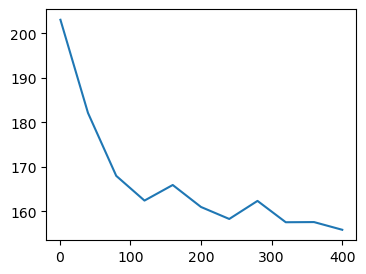

In [93]:
snapshot_manager = SnapshotManager(snapshot_dir=os.path.join('hub_model_snapshots', "m_var_1_0"), total_iterations=iterations)

ldf = snapshot_manager.load_training_losses()
_, ax = plt.subplots(figsize=[4,3])
ax.plot(ldf)
plt.show()

In [94]:
for k in forecasts:
    print(k, calc_loss(forecasts, k, test_targets, horizon))

m_var_0_0 tensor(0.1362)
m_var_1_0 tensor(0.1378)
median tensor(0.1347)


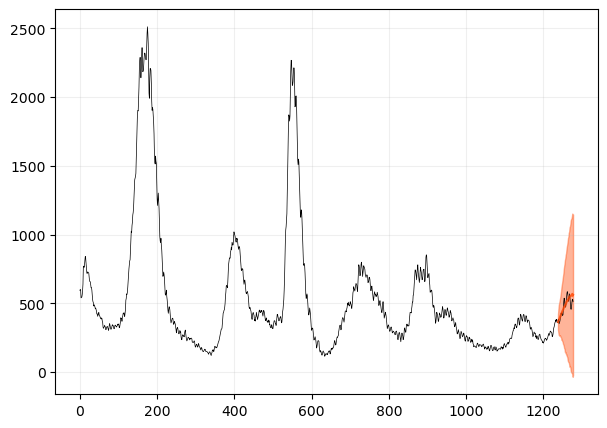

In [95]:
plotpred(forecasts, "median", 4, vals_train["nat_scale"], test_targets, horizon, lower_fc, upper_fc)

In [96]:
us_forecast = {}
us_upper = {}
us_lower = {}

## estimated correlations, to calculate var(sum)
##  (because var(sum) = sum(var) only for independent variables)
corr_mat = np.corrcoef(vals_train["nat_scale"])  

for k in forecasts:
    us_forecast[k] = forecasts[k].sum(axis=0,keepdims=True) ## sum mu on natural scale

    ## covar_i_j = correlation_i_j * std_i * std_j
    st_devs = np.sqrt(var_fc[k] * variance_scale) * inv_scale
    ## var(sum) = sum(covar) at each timepoint for which variance was forecast
    est_varsums = np.array([np.nansum(corr_mat * st_devs[:,i,None] * st_devs[:,i]) for i in range(st_devs.shape[1])])

    if data_is_log: ## variances are on log scale
        ## summing var(log) gives nonsense results; convert var(log) to approx var(natural), then sum?
        #approx_var = ( np.square(forecasts[k]) * var_fc[k] ).sum(axis=0,keepdims=True) 
        #approx_var = ( np.square(forecasts[k]) * (-1.0+np.exp(var_fc[k])) ).sum(axis=0,keepdims=True) 
        #s = np.sqrt(approx_var) * inv_scale
        #that doesn't look right either so...
        us_upper[k] = upper_fc[k].sum(axis=0,keepdims=True)
        us_lower[k] = lower_fc[k].sum(axis=0,keepdims=True)
    else: ## variances are on natural scale
        ## using estimated var(sum):
        s = np.sqrt(est_varsums)
        us_upper[k] = us_forecast[k] + 2.0*s
        us_lower[k] = us_forecast[k] - 2.0*s
        #if that doesn't work...
        #us_upper[k] = upper_fc[k].sum(axis=0,keepdims=True)
        #us_lower[k] = lower_fc[k].sum(axis=0,keepdims=True)
        

us_quantile = {}
for k in quantile_fc:

    ## covar_i_j = correlation_i_j * std_i * std_j
    st_devs = np.sqrt(var_fc[k] * variance_scale) * inv_scale
    ## var(sum) = sum(covar) at each timepoint for which variance was forecast
    est_varsums = np.array([np.nansum(corr_mat * st_devs[:,i,None] * st_devs[:,i]) for i in range(st_devs.shape[1])])

    if data_is_log:
        ## this isn't right, but it looks ok and computing var(sum) from var(logs) is tricky
        us_quantile[k] = quantile_fc[k].sum(axis=0,keepdims=True)
    else:
        ## using estimated var(sum):
        s = np.sqrt(est_varsums)
        V = [us_forecast[k] + x*s for x in Z]
        us_quantile[k] = np.stack(V,axis=2) ## [series, time, quantiles]
        #if that doesn't work...
        #us_quantile[k] = quantile_fc[k].sum(axis=0,keepdims=True)

us_train = vals_train["nat_scale"].sum(axis=0,keepdims=True)
us_test = test_targets.sum(axis=0,keepdims=True) if test_targets is not None else None


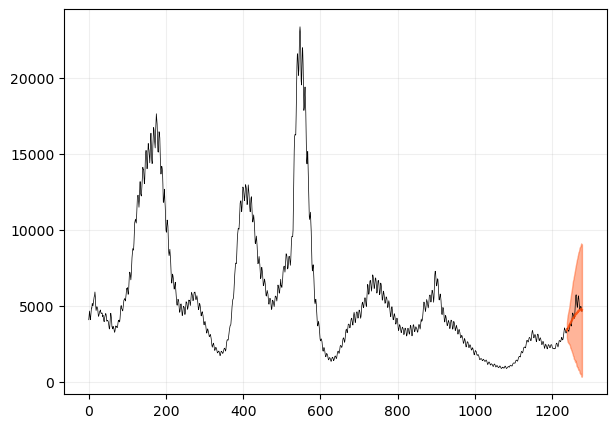

In [97]:
plotpred(us_forecast, "median", 0, us_train, us_test, horizon, us_lower, us_upper)

In [45]:
#us50 = {}
#us05 = {}
#us95 = {}
#for k in us_quantile:
#    us50[k] = us_quantile[k][:,:,11]
#    us05[k] = us_quantile[k][:,:,2]
#    us95[k] = us_quantile[k][:,:,20]
#us50["median"] = np.expand_dims(df_hub.loc[(df_hub["location"]=="US") & (df_hub["quantile"]=="0.500"),"value"].values, 0)
#us05["median"] = np.expand_dims(df_hub.loc[(df_hub["location"]=="US") & (df_hub["quantile"]=="0.050"),"value"].values, 0)
#us95["median"] = np.expand_dims(df_hub.loc[(df_hub["location"]=="US") & (df_hub["quantile"]=="0.950"),"value"].values, 0)
#plotpred(us50, "median", 0, us_train, us_test, horizon, us05, us95)

In [23]:
## process data for forecast hub

## forecast date: output file will contain forecast for this day forward; default = current local date
##
## NOTE: model generates a forecast starting with the day after the training data ends,
##   which may be in the past. But only forecast_date onward is written to the output file.
train_end_date = pd.to_datetime(data_index[-1])
#forecast_date = pd.to_datetime(train_end_date + pd.Timedelta(days=1))
forecast_date = pd.to_datetime(datetime.date.today()) 


In [24]:

## use ensembled forecasts; append US forecast derived above
q_ensemble = np.concatenate([quantile_fc["median"], us_quantile["median"]],axis=0) ## [location, time, quantile]
location_codes = df_targ.columns.to_list() + ["US"] ## fips codes
quantile_labels = [f'{x:.3f}' for x in qtiles]
date_indices = pd.date_range(train_end_date + pd.Timedelta(days=1), train_end_date + pd.Timedelta(days=q_ensemble.shape[1]))

dfs = []
## loop through each location in q_ensemble and make a dataframe with shape [date, value at each quantile]
for i in range(q_ensemble.shape[0]):
    df = pd.DataFrame(q_ensemble[i,:,:])
    df.columns = quantile_labels
    df.index = date_indices
    dfs.append(df.loc[forecast_date:,:].melt(ignore_index=False,var_name="quantile").reset_index(names="target_end_date"))

## concatenate the location dataframes and set index to location code
df_hub = pd.concat(dfs,keys=location_codes).droplevel(1).reset_index(names="location")

## add the rest of the columns required by forecast hub
df_hub.loc[:,"type"] = "quantile"
df_hub.loc[:,"forecast_date"] = forecast_date
df_hub.loc[:,"target"] = df_hub.target_end_date.map(lambda d: str((d - forecast_date).days) + " day ahead inc hosp")
df_hub.loc[:,"value"] = df_hub.loc[:,"value"].round(2)


In [37]:
## TODO: try an error dist that doesn't allow negative values
## for now, set them to 0
df_hub.loc[df_hub["value"]<0.0,"value"] = 0.0

In [41]:
#df_hub.loc[(df_hub["location"]=="US")&(df_hub["quantile"]=="0.500")]

In [39]:
# write to csv
hub_name = "OHT_JHU-nbxd"
filename = forecast_date.strftime("%Y-%m-%d") + "-" + hub_name + ".csv"
print("writing ",filename)
df_hub.to_csv(filename, index=False)

writing  2024-01-22-OHT_JHU-nbxd.csv


In [ ]:


## daily point forecasts for forecast hub, interpolated from weekly point forecasts
'''
ens_med = forecasts["median"].transpose()

## weekly forecasts correspond to the mean daily value in each week
## assume that this forecasts the value at the middle of each week
df_daily = pd.DataFrame(np.concatenate([
    np.concatenate([np.tile(np.nan,(3,ens_med.shape[1])),
                    ens_med[i,None],
                    np.tile(np.nan,(3,ens_med.shape[1]))])
    for i in range(ens_med.shape[0])]))

train_end_date = pd.to_datetime(data_index[-1])
df_daily.index = pd.date_range(train_end_date + pd.Timedelta(days=1), train_end_date + pd.Timedelta(weeks=ens_med.shape[0]))
df_daily.columns = df_targ.columns

## include the last data point for interpolation
df_daily.loc[train_end_date,:] = df_targ.iloc[-1,:]
df_daily.sort_index(inplace=True)
## don't try to interpolate past last prediction
df_daily = df_daily.iloc[:-3,:]

## because data points represent weekly avg, we want interpolation to over/under-shoot the linear case
##  when values change direction; cubic spline does this
df_daily = df_daily.interpolate(method="cubicspline").iloc[1:,:] ## remove helper point

## format for forecast hub

## forecast date: output file will contain forecast for this day forward; default = current local date
##
## NOTE: model generates a forecast starting with the day after the training data ends,
##   which may be in the past. But only forecast_date onward is written to the output file.
forecast_date = pd.to_datetime(datetime.date.today())
df_hub = df_daily.loc[forecast_date:,:].melt(ignore_index=False,var_name="location").reset_index(names="target_end_date")

df_hub.loc[:,"type"] = "point"
df_hub.loc[:,"quantile"] = "NA"
df_hub.loc[:,"forecast_date"] = forecast_date
df_hub.loc[:,"target"] = df_hub.target_end_date.map(lambda d: str((d - forecast_date).days) + " day ahead inc hosp")
df_hub.loc[:,"value"] = df_hub.loc[:,"value"].round(2)

filename = forecast_date.strftime("%Y-%m-%d") + "-OHT-nbx.csv"
print("writing ",filename)
df_hub.to_csv(filename, index=False)
'''